In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score
import time

In [2]:
######################################
#                                    #
# Add your path to the data set here #
#                                    #
######################################

file_list = np.asarray(os.listdir("./kvasir-instrument/images/images"))
image_path = "./kvasir-instrument/images/images/" 
mask_path = "./kvasir-instrument/masks/masks/"

In [3]:
# Import the data into python in batches by using this batch generator

def batch_generator(batch_size, gen_x): 
    batch_features = np.zeros((batch_size,256,256,3))
    batch_labels = np.zeros((batch_size,256,256,3)) 
    while True:
        for i in range(batch_size):
            batch_features[i] , batch_labels[i] = next(gen_x)
        yield batch_features, batch_labels

In [4]:
# This function generates data for trainig and validation

def generate_data(filelist, img_path, mask_path):
    while True:
        for i in filelist:
            # Read instrument image as a color image using OpenCV
            X_train = cv2.imread(img_path + i, cv2.IMREAD_COLOR )
            # Resize data to 256x256 pixels - you are of course free to choose whatever size you want
            X_train = cv2.resize(X_train, (256,256), interpolation= cv2.INTER_LINEAR )
            # The instrument images are stored in .jpg files and the corresponding masks are stored as png file
            # therefore it is necessary to change the extention of the filename to get the mask
            i = i.split(".")[0] + ".png"
            # Read the masks as color images using OpenCV
            y_mask = cv2.imread(mask_path + i, cv2.IMREAD_COLOR)
            # Resize mask to same size as instrument image (in this case 256x256 pixels) 
            y_mask = cv2.resize(y_mask, (256,256), interpolation= cv2.IMREAD_GRAYSCALE)
            # Convert mask to a grayscale image (black and white)
            _,y_mask = cv2.threshold(y_mask, 127, 255, cv2.THRESH_BINARY)
            y_mask = (y_mask/255).astype(int)
            yield X_train, y_mask

In [5]:
# This function imports data for testing

def generate_data_pred(filelist, img_path, mask_path):
    while True:
        for i in filelist:
            # Read instrument image as a color image using OpenCV - keep the original image size
            original_img = cv2.imread(img_path + i, cv2.IMREAD_COLOR )
            # Resize instrument image to 256x256 pixels - you are of course free to choose whatever size you want
            X_train = cv2.resize(original_img, (256,256), interpolation= cv2.INTER_LINEAR )
            # The instrument images are stored in .jpg files and the corresponding masks are stored as png file
            # therefore it is necessary to change the extention of the filename to get the mask
            i = i.split(".")[0] + ".png"
            # Read the masks as color images using OpenCV and keep the original mask size 
            original_mask = cv2.imread(mask_path + i, cv2.IMREAD_COLOR)
            # Resize mask to 256x256 pixels
            y_mask = cv2.resize(original_mask, (256,256), interpolation= cv2.IMREAD_GRAYSCALE)
            # Convert mask to a grayscale image (black and white)
            _,y_mask = cv2.threshold(y_mask, 127, 255, cv2.THRESH_BINARY)
            y_mask = (y_mask/255).astype(int)
            yield original_img, original_mask, X_train, y_mask

In [6]:
# computes the dice score 
# # The code is taken from: https://www.programcreek.com/python/?CodeExample=compute+dice
# Project: surface-distance   Author: deepmind  License: Apache License 2.0

def dice_score(mask_gt, mask_pred):
    """Computes soerensen-dice coefficient.

    compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
    and the predicted mask `mask_pred`.

    Args:
    mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    mask_pred: 3-dim Numpy array of type bool. The predicted mask.

    Returns:
    the dice coeffcient as float. If both masks are empty, the result is NaN.
    """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    if volume_sum == 0:
        return np.NaN
    volume_intersect = (mask_gt & mask_pred).sum()
    return 2*volume_intersect / volume_sum 

In [7]:
# These two functions can be used to implement the Dice loss
# The code is taken from: https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [8]:
# These two functions can be used to implement the Jaccard loss

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return 1-jacard_coef(y_true, y_pred)

In [9]:
# A Unet architechture taken from: https://keras.io/examples/vision/oxford_pets_image_segmentation/ 

def Unet(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model



54/53 [==============================] - 263s 5s/step - loss: 0.4972 - jacard_coef: 0.5028 - dice_coef: 0.9178 - val_loss: 0.8736 - val_jacard_coef: 0.1264 - val_dice_coef: 0.7506


C:\Users\Bjorn\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------------------------------------
Mask on top of image (overlay)


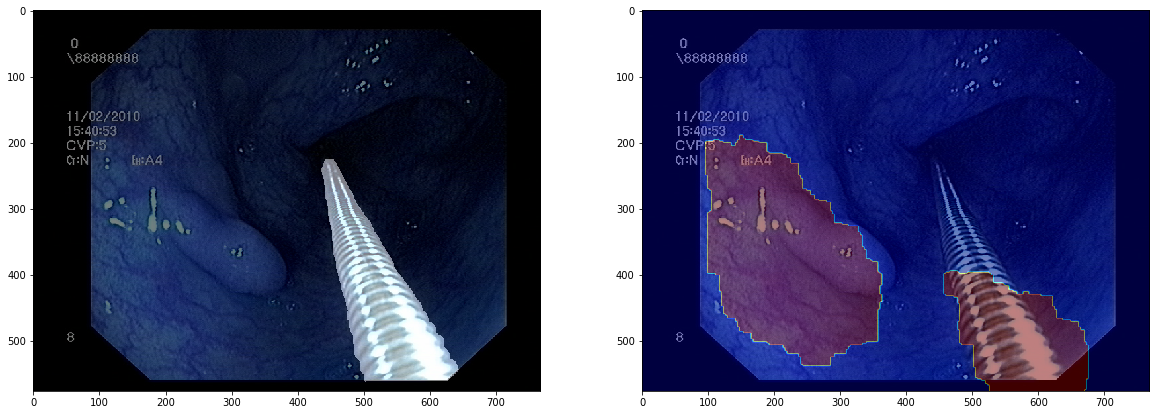

Only mask


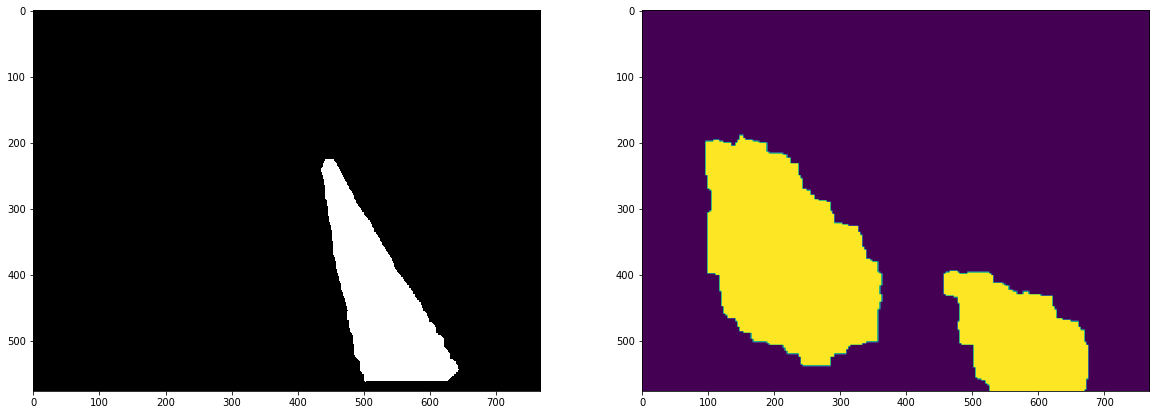

-------------------------------------------------------
-------------------------------------------------------
Mask on top of image (overlay)


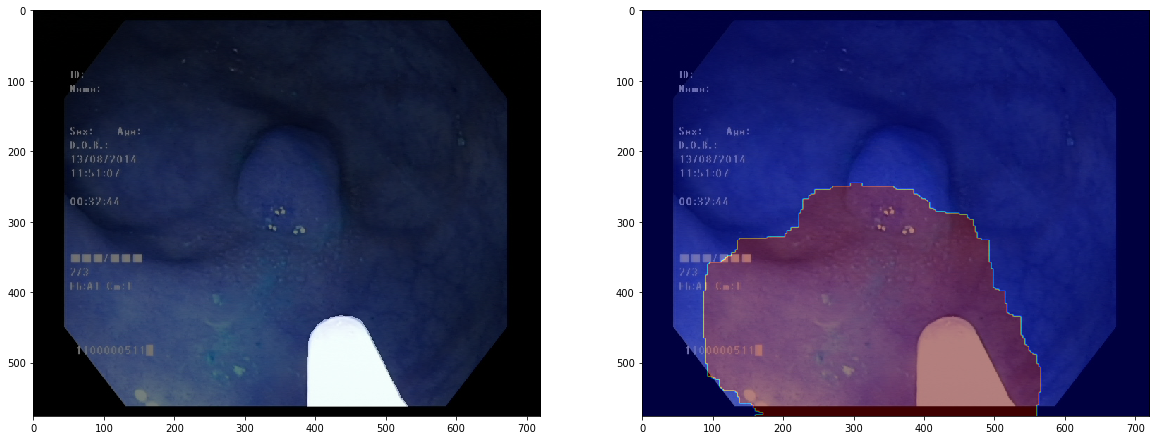

Only mask


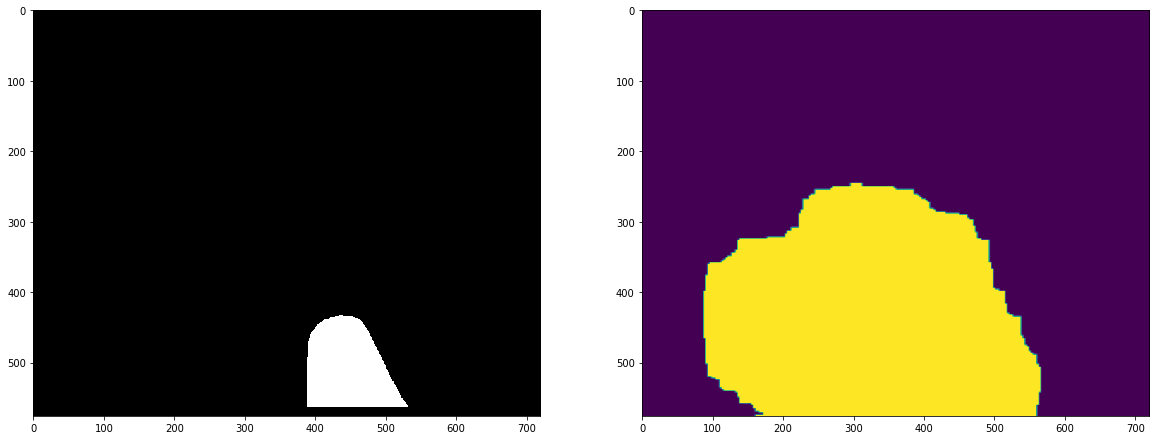

-------------------------------------------------------
-------------------------------------------------------
Mask on top of image (overlay)


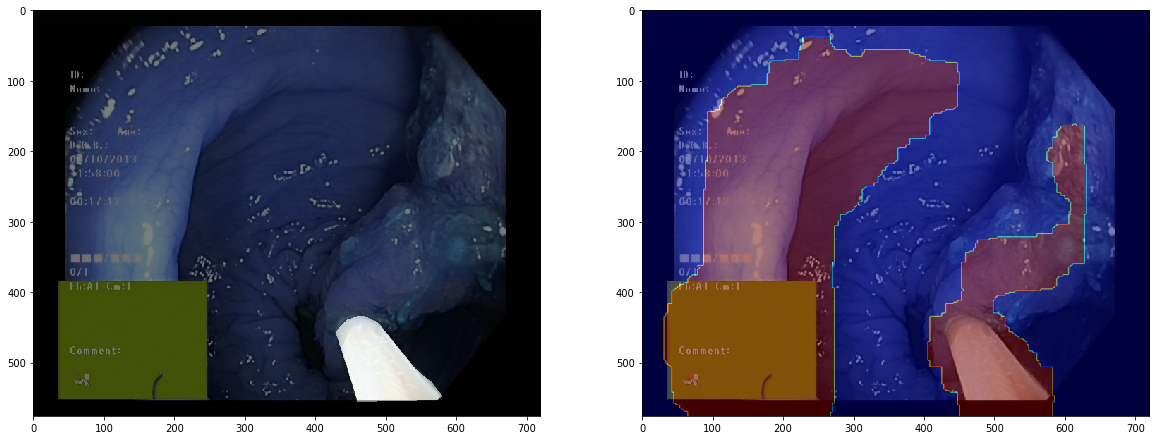

Only mask


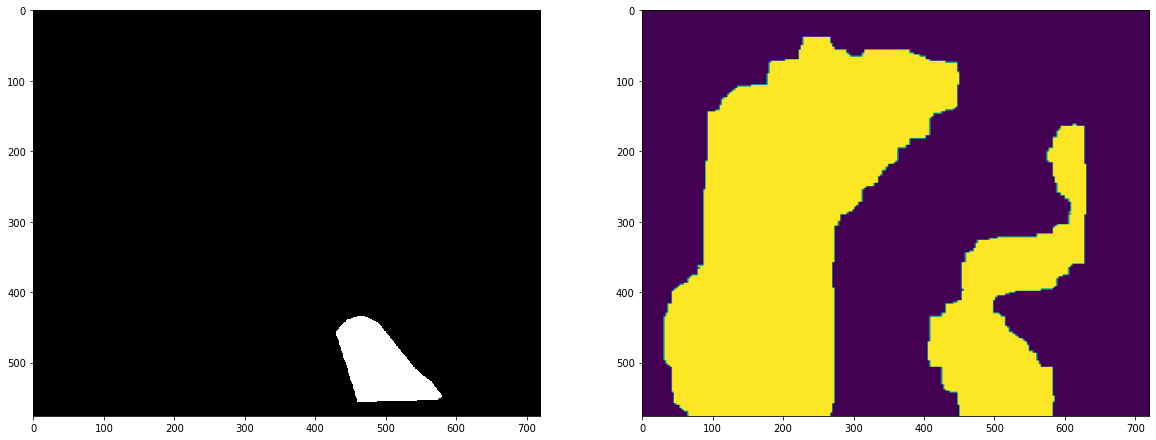

-------------------------------------------------------
-------------------------------------------------------
Mask on top of image (overlay)


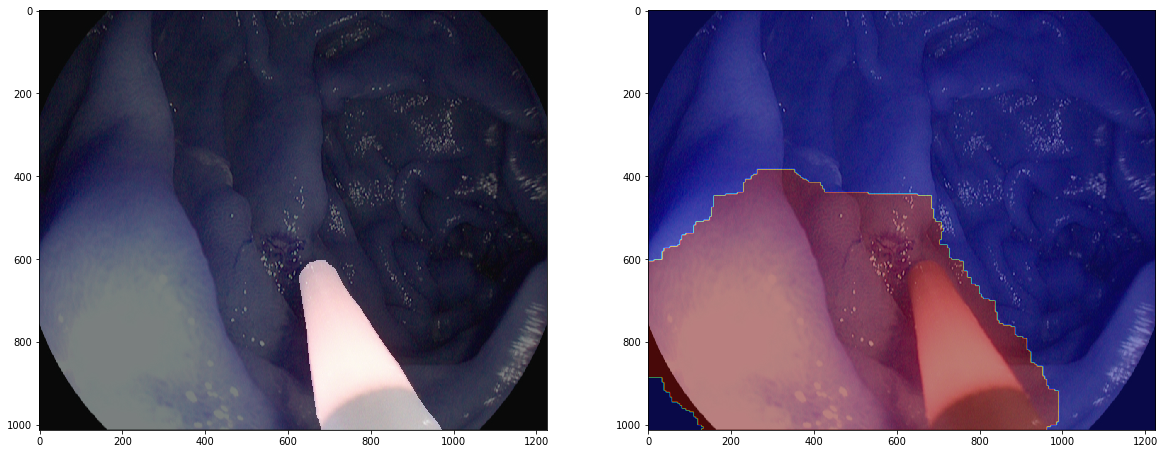

Only mask


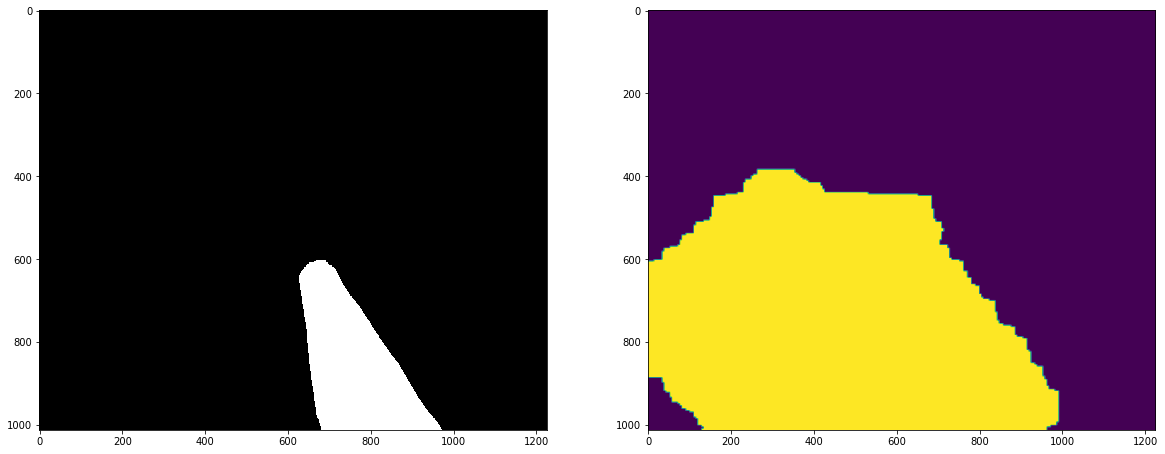

-------------------------------------------------------
-------------------------------------------------------
Mask on top of image (overlay)


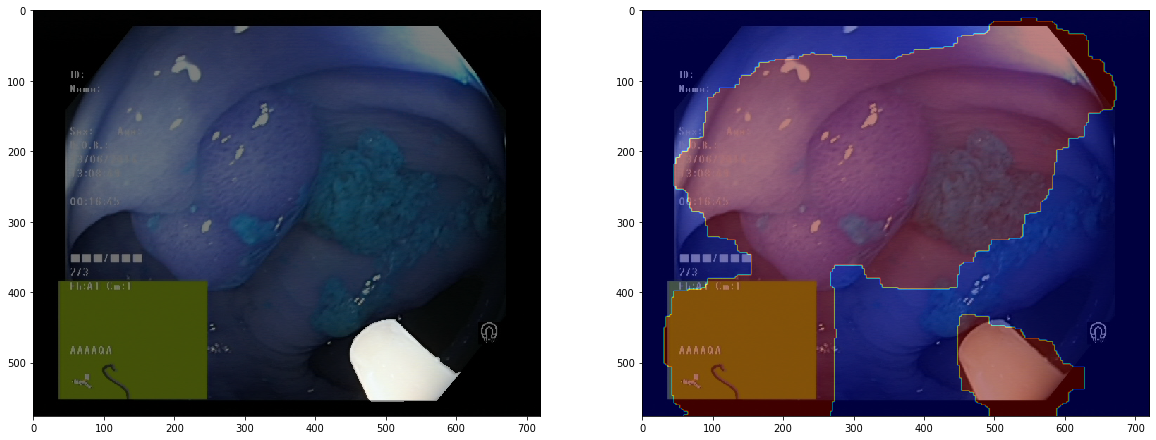

Only mask


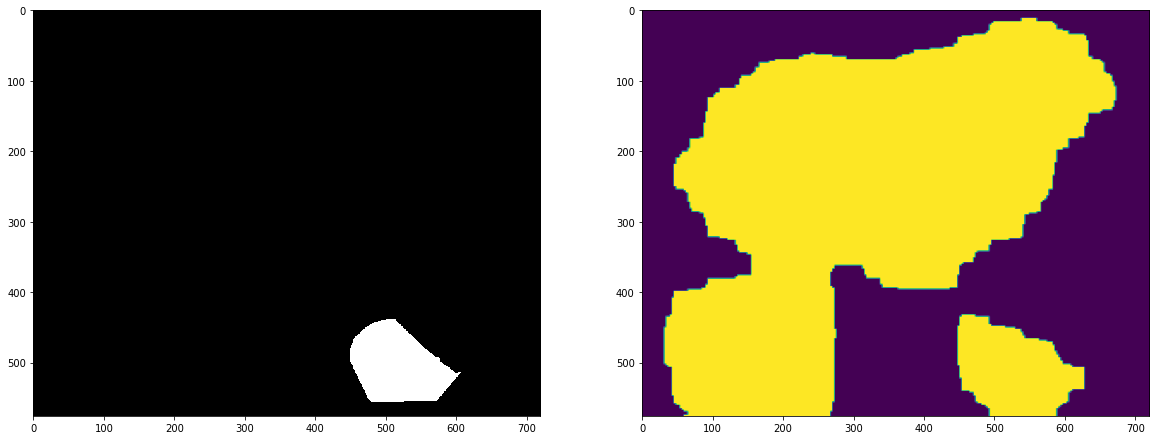

-------------------------------------------------------
--------------------------------------
Mean validation DICE (on resized data): 0.26580985177559713
Mean validation DICE (on original data): 0.26739055213958746
--------------------------------------
Mean validation Jaccard (on resized data): 0.10647063659918742
Mean validation Jaccard (on original data): 0.10660693542945149
--------------------------------------
Runtime 1-fold: 300.22209548950195 sec


In [ ]:
# Set hyperparameters and other variables
batchsize = 10
data_size = len(file_list)
num_epoch = 1

# K-fold splits
splits = 10
kf = KFold(n_splits=splits)
valsize = data_size // splits
trainsize = data_size - valsize

data_num = np.arange(data_size)

img_size = (256, 256)
num_classes = 3

# Arrays to store scores from each CV-fold
validation_dice_original = np.zeros([valsize,splits])
validation_dice_resized = np.zeros([valsize,splits])
validation_jaccard_original = np.zeros([valsize,splits])
validation_jaccard_resized = np.zeros([valsize,splits])

# A couter to keep track of current CV-fold
cv_count = 0

for train_index, val_index in kf.split(data_num):
    # Time each CV-fold
    time_start = time.time()
    # Define model
    model =  Unet(img_size, 3)
    # Compile model
    model.compile(optimizer='Adam', loss=jacard_coef_loss, metrics = [jacard_coef, dice_coef])
    # Train model
    model.fit(x=batch_generator(batchsize, generate_data(file_list[train_index], image_path, mask_path)), epochs=num_epoch, 
                            steps_per_epoch=(trainsize/batchsize), 
                            validation_steps=(valsize/batchsize),
                            validation_data=batch_generator(batchsize, generate_data(file_list[val_index], image_path, mask_path)), 
                            validation_freq=1, 
                            verbose = 1,
                            )
    # Define validation/test generator
    val_gen  = generate_data_pred(file_list[val_index], image_path, mask_path)
    for i in range(valsize):
        # Import one set of instrument image and mask - both as original and resized images
        original_img, original_mask, X, y_true = next(val_gen)
        # Get shape of original image
        original_shape = original_img.shape
        # Use the trained model to do prediction on the resized instrument image
        y_pred = model.predict(np.expand_dims(X,0))
        # Binarize prediction
        _,y_pred_thr = cv2.threshold(y_pred[0,:,:,0]*255, 127, 255, cv2.THRESH_BINARY)
        y_pred = (y_pred_thr/255).astype(int)
        # Score the model performance based on the predicted 256x256 mask
        dice_resized = dice_score(y_true[:,:,0],y_pred)
        jaccard_resized = jaccard_score(y_true[:,:,0],y_pred, average="macro")
        # Resize the predicted mask to the original size
        y_pred_original = cv2.resize(y_pred.astype(float), (original_shape[1],original_shape[0]), interpolation= cv2.INTER_LINEAR)
        # Score the model performance based on the original size of the mask
        dice_original = dice_score(original_mask[:,:,0],y_pred_original.astype(int)*255)
        jaccard_original = jaccard_score(original_mask[:,:,0],y_pred_original.astype(int)*255, average="macro")
        
        # Keep the dice and jaccard scores from the current predicion
        validation_dice_original[i,cv_count] = dice_original
        validation_dice_resized[i,cv_count] = dice_resized
        validation_jaccard_original[i,cv_count] = jaccard_original
        validation_jaccard_resized[i,cv_count] = jaccard_resized
        
        # Plot 5 examples fom the validation data.
        # The figure on the top left shows the image with an overlay of the ground truth mask 
        # The figure on the top right shows the image with an overlay of the predicted mask
        # The figure on the bottom left shows ground truth mask
        # The figure on the bottom left shows the predicted mask
        if i < 5:
            print("-------------------------------------------------------")
            print("Mask on top of image (overlay)")
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            plt.imshow(original_img, 'gray', interpolation='none')
            plt.imshow(original_mask/255.0, 'jet', interpolation='none', alpha=0.5)
            plt.subplot(1,2,2)
            plt.imshow(original_img, 'gray', interpolation='none')
            plt.imshow(y_pred_original, 'jet', interpolation='none', alpha=0.5)
            plt.show()
            print("Only mask")
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            plt.imshow(original_mask/255.0, interpolation='none')
            plt.subplot(1,2,2)
            plt.imshow(y_pred_original, interpolation='none')
            plt.show()
            print("-------------------------------------------------------")
            
    # Calculate the mean dice and jaccard scores for all predicion in this CV-fold
    dice_resized_mean = validation_dice_resized[:,cv_count].mean()
    dice_original_mean = validation_dice_original[:,cv_count].mean()
    jaccard_resized_mean = validation_jaccard_resized[:,cv_count].mean()
    jaccard_original_mean = validation_jaccard_original[:,cv_count].mean()
        
    print("--------------------------------------")
    print("Mean validation DICE (on resized data):", dice_resized_mean) 
    print("Mean validation DICE (on original data):", dice_original_mean)
    print("--------------------------------------")
    print("Mean validation Jaccard (on resized data):", jaccard_resized_mean) 
    print("Mean validation Jaccard (on original data):", jaccard_original_mean)
    print("--------------------------------------")
    cv_count +=1
    runtime = time.time() - time_start 
    print('Runtime {}-fold: {} sec'.format(cv_count,runtime))
